# **Movie Analysis Notebook**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
import math
import sqlite3
import zipfile
import warnings
warnings.filterwarnings('ignore')

In [2]:
movie = pd.read_csv('../data/zippedData/tmdb.movies.csv.gz')
movie_info = pd.read_csv('../data/zippedData/rt.movie_info.tsv.gz',sep='\t', compression='gzip')
movie_review = pd.read_csv('../data/zippedData/rt.reviews.tsv.gz', sep='\t', encoding='latin1')
movie_gross = pd.read_csv('../data/zippedData/bom.movie_gross.csv.gz')
movie_budget = pd.read_csv('../data/zippedData/tn.movie_budgets.csv.gz')
conn = sqlite3.connect('../data/zippedData/im.db.zip')

In [3]:
#specify the path to the zip file
zip_file_path = '../data/zippedData/im.db.zip'

#Extract the SQLite database file from the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('../unzippedData')

#connect to extracted SQLite database
database_path = '../unzippedData/im.db'
conn = sqlite3.connect(database_path)

## **Movie DF EDA**

In [4]:
# drop the 'Unnamed: 0' column from the movie dataframe
movie.drop('Unnamed: 0', axis=1, inplace=True)

In [5]:
# convert release_date to datetime and filter for movies
movie['release_date'] = pd.to_datetime(movie['release_date'])

# create a new column called release month that takes the month from release_date
movie['release_month'] = movie['release_date'].dt.month

# create a column called release_year and take just the year from release_date
movie['release_year'] = pd.to_datetime(movie['release_date']).dt.year

# drop the release_date column
movie.drop('release_date', axis=1, inplace=True)

## **Movie_Budget EDA**

In [6]:
# convert release_date to datetime format
movie_budget['release_date'] = pd.to_datetime(movie_budget['release_date'])

# create new columns release_year and release_month
movie_budget['release_year'] = movie_budget['release_date'].dt.year
movie_budget['release_month'] = movie_budget['release_date'].dt.month

# drop release_date column from movie_budget dataframe
movie_budget.drop('release_date', axis=1, inplace=True)

# convert production_budget, domestic_gross, and worldwide_gross to numerical values
movie_budget['production_budget'] = pd.to_numeric(movie_budget['production_budget'].str.replace('$','').str.replace(',',''), errors='coerce')
movie_budget['domestic_gross'] = pd.to_numeric(movie_budget['domestic_gross'].str.replace('$','').str.replace(',',''), errors='coerce')
movie_budget['worldwide_gross'] = pd.to_numeric(movie_budget['worldwide_gross'].str.replace('$','').str.replace(',',''), errors='coerce')

# Merging Movie and Movie_Budget

In [7]:
# merge movie_budget and movie dataframes using 'movie' and 'title' columns respectively
merged_df = pd.merge(movie_budget, movie, left_on='movie', right_on='title')

In [8]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2385 entries, 0 to 2384
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id_x               2385 non-null   int64  
 1   movie              2385 non-null   object 
 2   production_budget  2385 non-null   int64  
 3   domestic_gross     2385 non-null   int64  
 4   worldwide_gross    2385 non-null   int64  
 5   release_year_x     2385 non-null   int32  
 6   release_month_x    2385 non-null   int32  
 7   genre_ids          2385 non-null   object 
 8   id_y               2385 non-null   int64  
 9   original_language  2385 non-null   object 
 10  original_title     2385 non-null   object 
 11  popularity         2385 non-null   float64
 12  title              2385 non-null   object 
 13  vote_average       2385 non-null   float64
 14  vote_count         2385 non-null   int64  
 15  release_month_y    2385 non-null   int32  
 16  release_year_y     2385 

In [9]:
merged_df.drop(['id_y', 'original_title', 'title', 'release_year_x', 'release_month_x'], axis=1, inplace=True)

In [10]:
merged_df.rename(columns={'id_x': 'id', 'release_year_y': 'release_year', 'release_month_y': 'release_month'}, inplace=True)

In [11]:
merged_df.drop_duplicates(subset='movie', keep='last', inplace=True)

In [12]:
merged_df['net_profit'] = merged_df['worldwide_gross'] - merged_df['production_budget']

In [13]:
#create columns for low, mid, and high budgets films 
def budget(x): 
    if x < 5000000: 
        budget = 'low'
    if 5000000 <= x < 50000000: 
        budget = 'mid'
    if x >= 50000000:
        budget = 'high'
    return budget


In [14]:
#feature engineering
merged_df['budget'] = merged_df['production_budget'].apply(lambda x: budget(x))

In [15]:
merged_df.head()

,id,movie,production_budget,domestic_gross,worldwide_gross,genre_ids,original_language,popularity,vote_average,vote_count,release_month,release_year,net_profit,budget
0,1,Avatar,425000000,760507625,2776345279,"[28, 12, 14, 878]",en,26.526,7.4,18676,12,2009,2351345279,high
1,2,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,"[12, 28, 14]",en,30.579,6.4,8571,5,2011,635063875,high
2,4,Avengers: Age of Ultron,330600000,459005868,1403013963,"[28, 12, 878]",en,44.383,7.3,13457,5,2015,1072413963,high
3,7,Avengers: Infinity War,300000000,678815482,2048134200,"[12, 28, 14]",en,80.773,8.3,13948,4,2018,1748134200,high
5,9,Justice League,300000000,229024295,655945209,"[28, 12, 14, 878]",en,34.953,6.2,7510,11,2017,355945209,high


In [16]:
merged_df['profit_margin'] = round(((merged_df['worldwide_gross'] - merged_df['production_budget']) / merged_df['worldwide_gross'] * 100), 2)

In [17]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1924 entries, 0 to 2384
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 1924 non-null   int64  
 1   movie              1924 non-null   object 
 2   production_budget  1924 non-null   int64  
 3   domestic_gross     1924 non-null   int64  
 4   worldwide_gross    1924 non-null   int64  
 5   genre_ids          1924 non-null   object 
 6   original_language  1924 non-null   object 
 7   popularity         1924 non-null   float64
 8   vote_average       1924 non-null   float64
 9   vote_count         1924 non-null   int64  
 10  release_month      1924 non-null   int32  
 11  release_year       1924 non-null   int32  
 12  net_profit         1924 non-null   int64  
 13  budget             1924 non-null   object 
 14  profit_margin      1924 non-null   float64
dtypes: float64(3), int32(2), int64(6), object(4)
memory usage: 225.5+ KB


In [18]:

# Remove the '[' and ']' from the values in 'genre_ids' column
merged_df['genre_ids'] = merged_df['genre_ids'].str.replace('[', '').str.replace(']', '')



In [19]:
merged_df.head()

,id,movie,production_budget,domestic_gross,worldwide_gross,genre_ids,original_language,popularity,vote_average,vote_count,release_month,release_year,net_profit,budget,profit_margin
0,1,Avatar,425000000,760507625,2776345279,"28, 12, 14, 878",en,26.526,7.4,18676,12,2009,2351345279,high,84.69
1,2,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,"12, 28, 14",en,30.579,6.4,8571,5,2011,635063875,high,60.73
2,4,Avengers: Age of Ultron,330600000,459005868,1403013963,"28, 12, 878",en,44.383,7.3,13457,5,2015,1072413963,high,76.44
3,7,Avengers: Infinity War,300000000,678815482,2048134200,"12, 28, 14",en,80.773,8.3,13948,4,2018,1748134200,high,85.35
5,9,Justice League,300000000,229024295,655945209,"28, 12, 14, 878",en,34.953,6.2,7510,11,2017,355945209,high,54.26


In [20]:




# Define the genre dictionary
gen_dict = {'28': 'Action', '12': 'Adventure', '16': 'Animation', '35': 'Comedy', '80': 'Crime',
            '99': 'Documentary', '18': 'Drama', '10751': 'Family', '14': 'Fantasy', '36': 'History',
            '27': 'Horror', '10402': 'Music', '9648': 'Mystery', '10749': 'Romance', '878': 'Science Fiction',
            '10770': 'TV Movie', '53': 'Thriller', '10752': 'War', '37': 'Western'}

def genre_names(x):
    try:  
        st = str(x)
        names = st.split(',')
        names_list = []
        for name in names:
            na_strip = name.strip()
            na = gen_dict[na_strip]
            names_list.append(na)
        return names_list
    except: 
       return None 

# Apply the conversion to create a new column 'genres' with string values from 'genre_ids'
#merged_df['genres'] = merged_df['genres'].apply(lambda x: ', '.join(gen_dict.get(id, '') for id in x.split(', ')))




In [21]:
merged_df['genres'] = merged_df['genre_ids'].apply(lambda x: genre_names(x))

In [22]:
merged_df.head()

,id,movie,production_budget,domestic_gross,worldwide_gross,genre_ids,original_language,popularity,vote_average,vote_count,release_month,release_year,net_profit,budget,profit_margin,genres
0,1,Avatar,425000000,760507625,2776345279,"28, 12, 14, 878",en,26.526,7.4,18676,12,2009,2351345279,high,84.69,"[Action, Adventure, Fantasy, Science Fiction]"
1,2,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,"12, 28, 14",en,30.579,6.4,8571,5,2011,635063875,high,60.73,"[Adventure, Action, Fantasy]"
2,4,Avengers: Age of Ultron,330600000,459005868,1403013963,"28, 12, 878",en,44.383,7.3,13457,5,2015,1072413963,high,76.44,"[Action, Adventure, Science Fiction]"
3,7,Avengers: Infinity War,300000000,678815482,2048134200,"12, 28, 14",en,80.773,8.3,13948,4,2018,1748134200,high,85.35,"[Adventure, Action, Fantasy]"
5,9,Justice League,300000000,229024295,655945209,"28, 12, 14, 878",en,34.953,6.2,7510,11,2017,355945209,high,54.26,"[Action, Adventure, Fantasy, Science Fiction]"


In [23]:
merged_df.dropna(subset='genres', inplace=True)

In [24]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1891 entries, 0 to 2384
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 1891 non-null   int64  
 1   movie              1891 non-null   object 
 2   production_budget  1891 non-null   int64  
 3   domestic_gross     1891 non-null   int64  
 4   worldwide_gross    1891 non-null   int64  
 5   genre_ids          1891 non-null   object 
 6   original_language  1891 non-null   object 
 7   popularity         1891 non-null   float64
 8   vote_average       1891 non-null   float64
 9   vote_count         1891 non-null   int64  
 10  release_month      1891 non-null   int32  
 11  release_year       1891 non-null   int32  
 12  net_profit         1891 non-null   int64  
 13  budget             1891 non-null   object 
 14  profit_margin      1891 non-null   float64
 15  genres             1891 non-null   object 
dtypes: float64(3), int32(2), int6

In [25]:
def make_action(i, genre):
    if (genre) in i:
        return 1
    else: 
        return 0



In [26]:
#merged_df['Action'] = merged_df['genres'].apply(lambda x: make_action(x))
merged_df['Adventure'] = merged_df['genres'].apply(lambda x: make_action(x, 'Adventure'))


In [27]:
genres = list(gen_dict.values())
genres

for genre in genres: 
    merged_df[genre] = merged_df['genres'].apply(lambda x: make_action(x, genre))

In [28]:
#Looking at which genres appear most in each budget range  
merged_df.groupby('budget')[genres].sum()

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
budget,,,,,,,,,,,,,,,,,,,
high,232,215,86,142,44,9,126,113,115,16,28,8,27,33,109,3,111,17,8
low,44,22,8,106,37,41,221,15,18,4,112,10,41,56,37,4,134,6,7
mid,196,69,29,336,164,23,522,62,46,54,120,33,73,149,73,2,282,29,8


In [29]:
#create budget dataframes
high_df = merged_df[merged_df['budget'] == 'high']
mid_df = merged_df[merged_df['budget'] == 'mid']
low_df = merged_df[merged_df['budget'] == 'low']

In [30]:
#calculate which genre groups are best in high budget by looking at top net_profits
top_net_high = high_df.sort_values('net_profit', ascending=False)[:100]
top_net_high['genres'].value_counts()[:15]

genres
[Action, Adventure, Science Fiction]             6
[Action, Adventure, Fantasy]                     6
[Action, Adventure, Fantasy, Science Fiction]    5
[Action, Science Fiction, Adventure]             3
[Animation, Family, Comedy]                      3
[Adventure, Action, Science Fiction]             3
[Adventure, Fantasy, Action]                     2
[Action, Crime, Drama, Thriller]                 2
[Documentary]                                    2
[Action, Adventure, Comedy, Fantasy]             2
[Animation, Comedy, Family]                      2
[Adventure, Action, Fantasy]                     2
[Action, Crime, Thriller]                        2
[Animation, Family]                              2
[Action, Thriller, Crime]                        1
Name: count, dtype: int64

In [31]:
#calculate average net profits for each genre tag in high budget category
high_np_counts = {}

def get_mean_np(genre, df):
    new_df = df[df[genre] == 1]
    ave_np = new_df['net_profit'].mean()
    high_np_counts[genre] = int(ave_np)
    return int(ave_np)

for genre in genres: 
    get_mean_np(genre, high_df)

(sorted(high_np_counts.items(), key=lambda x: x[1]))


[('TV Movie', -5328087),
 ('History', 56417857),
 ('Horror', 114314022),
 ('Western', 124433113),
 ('Romance', 132359307),
 ('Mystery', 143855669),
 ('Music', 146386764),
 ('War', 149279833),
 ('Drama', 163992132),
 ('Documentary', 169138219),
 ('Thriller', 176097808),
 ('Crime', 207923921),
 ('Comedy', 242712354),
 ('Action', 283110830),
 ('Family', 283904633),
 ('Fantasy', 290206880),
 ('Science Fiction', 322883242),
 ('Adventure', 328536649),
 ('Animation', 334292676)]

In [32]:
#calculate which genre groups are best in mid budget by looking at top net_profits
top_net_mid = mid_df.sort_values('net_profit', ascending=False)[:100]
top_net_mid['genres'].value_counts()[:15]

genres
[Drama]                      7
[Comedy]                     6
[Comedy, Romance]            5
[Horror]                     4
[Drama, Romance]             3
[Drama, Comedy]              3
[Action, Comedy, Crime]      3
[Comedy, Crime]              3
[Drama, History]             3
[Action, Crime, Thriller]    2
[Comedy, Drama]              2
[Drama, Thriller]            2
[Comedy, Music]              2
[Thriller, Drama]            2
[Comedy, Drama, Romance]     2
Name: count, dtype: int64

In [33]:
#calculate average net profits for each genre tag in mid budget category
mid_np_counts = {}

def get_mean_np(genre, df):
    new_df = df[df[genre] == 1]
    ave_np = new_df['net_profit'].mean()
    mid_np_counts[genre] = int(ave_np)
    return int(ave_np)

for genre in genres: 
    get_mean_np(genre, mid_df)

(sorted(mid_np_counts.items(), key=lambda x: x[1]))

[('Western', 14450654),
 ('Documentary', 14592254),
 ('War', 24718167),
 ('History', 26712004),
 ('Crime', 29058464),
 ('Drama', 31777149),
 ('Adventure', 32400095),
 ('Thriller', 36084871),
 ('Action', 38683955),
 ('Mystery', 40748378),
 ('Music', 44627847),
 ('Comedy', 46198752),
 ('Animation', 48140471),
 ('Science Fiction', 50709519),
 ('Romance', 51230328),
 ('Fantasy', 51711031),
 ('Horror', 53353449),
 ('Family', 58880242),
 ('TV Movie', 64911219)]

In [34]:
#calculate which genre groups are best in low budget by looking at top net_profits
top_net_low = low_df.sort_values('net_profit', ascending=False)[:100]
top_net_low['genres'].value_counts()[:15]

genres
[Drama]                              15
[Horror, Thriller]                    8
[Comedy, Drama]                       5
[Drama, Romance]                      5
[Horror]                              4
[Thriller, Horror]                    3
[Comedy, Horror]                      3
[Documentary]                         3
[Comedy, Documentary]                 2
[Horror, Thriller, Mystery]           2
[Drama, Horror]                       2
[Drama, Romance, Comedy]              2
[Drama, Thriller]                     2
[Drama, Music, Romance, Comedy]       1
[Romance, Fantasy, Family, Drama]     1
Name: count, dtype: int64

In [35]:
#calculate average net profits for each genre tag in low budget category
low_np_counts = {}

def get_mean_np(genre, df):
    new_df = df[df[genre] == 1]
    ave_np = new_df['net_profit'].mean()
    low_np_counts[genre] = int(ave_np)
    return int(ave_np)

for genre in genres: 
    get_mean_np(genre, low_df)

(sorted(low_np_counts.items(), key=lambda x: x[1]))

[('Western', -715551),
 ('Action', -340436),
 ('Animation', 986629),
 ('Documentary', 1076981),
 ('TV Movie', 1412500),
 ('Adventure', 1859364),
 ('Comedy', 2029479),
 ('Crime', 2789845),
 ('War', 2913631),
 ('History', 4063101),
 ('Drama', 4687023),
 ('Music', 5288701),
 ('Science Fiction', 6309985),
 ('Mystery', 7909698),
 ('Romance', 8014612),
 ('Thriller', 8573673),
 ('Horror', 12380404),
 ('Fantasy', 19685560),
 ('Family', 20922073)]

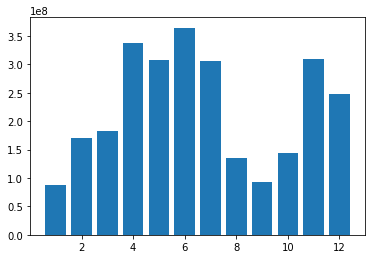

In [36]:
#calculate best month to release in high budget 
high_monthly = high_df.groupby('release_month')['net_profit'].mean()
plt.bar(x=high_monthly.index, height=high_monthly.values);

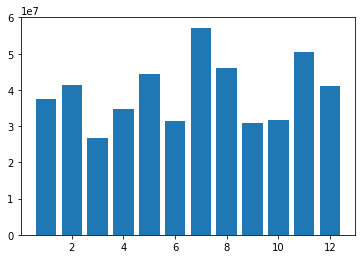

In [37]:
#calculate the best month to release in mid budget
mid_monthly = mid_df.groupby('release_month')['net_profit'].mean()
plt.bar(x=mid_monthly.index, height=mid_monthly.values);

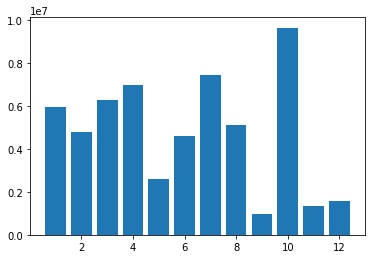

In [38]:
#calculate the best month to release in low budget
low_monthly = low_df.groupby('release_month')['net_profit'].mean()
plt.bar(x=low_monthly.index, height=low_monthly.values);

# Conclusion/Findings